# Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

#visualization libraries
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder #label encoding for categorical columns

# Read Data

In [2]:
customers = pd.read_csv("../input/brazilian-ecommerce/olist_customers_dataset.csv")
geolocation = pd.read_csv("../input/brazilian-ecommerce/olist_geolocation_dataset.csv")
items = pd.read_csv("../input/brazilian-ecommerce/olist_order_items_dataset.csv")
payments = pd.read_csv("../input/brazilian-ecommerce/olist_order_payments_dataset.csv")
reviews = pd.read_csv("../input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
orders = pd.read_csv("../input/brazilian-ecommerce/olist_orders_dataset.csv")
product = pd.read_csv("../input/brazilian-ecommerce/olist_products_dataset.csv")
sellers = pd.read_csv("../input/brazilian-ecommerce/olist_sellers_dataset.csv")
products_category = pd.read_csv("../input/brazilian-ecommerce/product_category_name_translation.csv")

print(customers.shape)
print(geolocation.shape)
print(items.shape)
print(payments.shape)
print(reviews.shape)
print(orders.shape)
print(product.shape)
print(sellers.shape)
print(products_category.shape)

(99441, 5)
(1000163, 5)
(112650, 7)
(103886, 5)
(99224, 7)
(99441, 8)
(32951, 9)
(3095, 4)
(71, 2)


# Labelling Target

### merging trx with customers

In [3]:
orders2  = orders[((orders["order_status"] != "canceled") & (orders["order_status"] != "unavailable"))]

In [4]:
cust_orders = pd.merge(customers[["customer_id","customer_unique_id"]], orders2[["customer_id","order_purchase_timestamp","order_id"]], on = "customer_id", how = "left")
cust_orders.shape

(99441, 4)

In [5]:
cust_orders

,customer_id,customer_unique_id,order_purchase_timestamp,order_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f
...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,6760e20addcf0121e9d58f2f1ff14298
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,9ec0c8947d973db4f4e8dcf1fbfa8f1b
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,fed4434add09a6f332ea398efd656a5c
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,e31ec91cea1ecf97797787471f98a8c2


### Customer never buy

In [6]:
cust_orders[cust_orders["order_purchase_timestamp"].isna()]

,customer_id,customer_unique_id,order_purchase_timestamp,order_id
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,NaN,NaN
288,5bfe800011656c0afb81db64519982db,0071f46a072a9ae25bbe4438b15efe9c,NaN,NaN
373,b08064e24083fee8fbe8797902b07ecd,035f60af6e7d7f78470e9443be08d339,NaN,NaN
378,3ba47b09546c2da91ef141efce2d5888,b8c37ee810b38c416022e1c9f51e740c,NaN,NaN
380,cfffbb322333151f8df6398a8c3340db,0dc0731aafd5659410244092b0dc7d65,NaN,NaN
...,...,...,...,...
98746,ef775ae2f3b831b79dd2e9bcf77bfb06,46c0a00dac020d24bfdfbc8b214d54de,NaN,NaN
98786,d9335c099e6943d88ac5f8a7cb418b66,22af178809fa6887af2cc4f7d7bdc0bc,NaN,NaN
99007,2034cc6d6d517007a9ba3e22ba643344,cb47d51801e7379766c5cd8ff623f37f,NaN,NaN
99105,882b44646ab3f186597b1622a9443ff9,639b4096a4e5c96549a9bb495ca4871e,NaN,NaN


### Customer buy

In [7]:
cust_orders_buy = cust_orders[~cust_orders["order_purchase_timestamp"].isna()]
cust_orders_buy

,customer_id,customer_unique_id,order_purchase_timestamp,order_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f
...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,6760e20addcf0121e9d58f2f1ff14298
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,9ec0c8947d973db4f4e8dcf1fbfa8f1b
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,fed4434add09a6f332ea398efd656a5c
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,e31ec91cea1ecf97797787471f98a8c2


In [8]:
cust_orders_buy2 = cust_orders_buy.groupby(["customer_unique_id","order_purchase_timestamp"]).count().reset_index()

In [9]:
cust_orders_buy2

,customer_unique_id,order_purchase_timestamp,customer_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,1
...,...,...,...,...
97919,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,1,1
97920,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,1
97921,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,1
97922,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,1,1


In [10]:
from datetime import datetime

cust_orders_buy2["order_purchase_timestamp"] = pd.to_datetime(cust_orders_buy2["order_purchase_timestamp"])
cust_orders_buy2['order_purchase_timestamp'] = cust_orders_buy2['order_purchase_timestamp'].dt.strftime('%Y-%m')
cust_orders_buy2["order_purchase_timestamp"] = pd.to_datetime(cust_orders_buy2["order_purchase_timestamp"])

In [11]:
cust_orders_buy2

,customer_unique_id,order_purchase_timestamp,customer_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1
...,...,...,...,...
97919,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1
97920,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1
97921,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1
97922,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1


In [12]:
size = cust_orders_buy2.shape[0]

a = []
for i in range (size-1) :
    if cust_orders_buy2.iloc[i,0] == cust_orders_buy2.iloc[i+1,0] :
        a.append((cust_orders_buy2.iloc[i+1,1] - cust_orders_buy2.iloc[i,1])/np.timedelta64(1,'M'))
    else :
        a.append((cust_orders_buy2.iloc[i,1] - cust_orders_buy2.iloc[i,1])/np.timedelta64(1,'M'))

In [13]:
diff = pd.DataFrame(a, columns = ["diff"])
diff = round(diff)
diff

,diff
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
97918,0.0
97919,0.0
97920,0.0
97921,0.0


In [14]:
cust_orders_buy3 = pd.concat([cust_orders_buy2, diff], axis=1)
cust_orders_buy3["diff"] = cust_orders_buy3["diff"].fillna(0)
cust_orders_buy3

,customer_unique_id,order_purchase_timestamp,customer_id,order_id,diff
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1,0.0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,1,0.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0.0
...,...,...,...,...,...
97919,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1,0.0
97920,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1,0.0
97921,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0.0
97922,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0.0


In [15]:
def flags(df) : 
    if df["diff"] <= 0 : 
        return 1
    elif df["diff"] <= 3 :
        return 0
    else :
        return 1

    
cust_orders_buy3["flagging"] = cust_orders_buy3.apply(flags, axis =1 )

definisi churn di sini adalah jika customer pernah melakukan 1 kali transaksi sukses, lalu tidak pernah lagi transaksi hingga sekarang, maka akan dianggap churn (semua cust yang hanya pernah melakukan 1 kali transaksi sukses {!= [canceled, unavailable]} akan dianggap churn)

In [16]:
cust_orders_buy3["flagging"].value_counts()

1    96950
0      974
Name: flagging, dtype: int64

In [17]:
cust_orders_buy3

,customer_unique_id,order_purchase_timestamp,customer_id,order_id,diff,flagging
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1,0.0,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,1,0.0,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0.0,1
...,...,...,...,...,...,...
97919,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1,0.0,1
97920,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1,0.0,1
97921,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0.0,1
97922,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0.0,1


In [18]:
# cust_orders_buy3[cust_orders_buy3[['customer_unique_id', 'order_purchase_timestamp']].duplicated() == True]
cust_orders_buy3[cust_orders_buy3['customer_unique_id'] == 'fed2005ccab4fcf1a40ebdaff032a148']

,customer_unique_id,order_purchase_timestamp,customer_id,order_id,diff,flagging
97462,fed2005ccab4fcf1a40ebdaff032a148,2017-06-01,1,1,0.0,1
97463,fed2005ccab4fcf1a40ebdaff032a148,2017-06-01,1,1,0.0,1


In [19]:
label = cust_orders_buy3.groupby(['customer_unique_id','order_purchase_timestamp'])[['flagging']].first().reset_index()
label

,customer_unique_id,order_purchase_timestamp,flagging
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1
...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1


In [20]:
label[label['customer_unique_id'] == 'fed2005ccab4fcf1a40ebdaff032a148']

,customer_unique_id,order_purchase_timestamp,flagging
96408,fed2005ccab4fcf1a40ebdaff032a148,2017-06-01,1


# Feature Engineering

## Kategori Reviews

In [21]:
orders_review = pd.merge(orders2[["customer_id","order_purchase_timestamp","order_id"]],reviews[["order_id","review_score"]], on = "order_id", how = "left")
orders_review.shape

(98752, 4)

In [22]:
orders_review['order_purchase_timestamp'] = pd.to_datetime(orders_review['order_purchase_timestamp']).dt.strftime('%Y-%m')
orders_review['order_purchase_timestamp'] = pd.to_datetime(orders_review['order_purchase_timestamp'])

orders_review.dtypes

customer_id                         object
order_purchase_timestamp    datetime64[ns]
order_id                            object
review_score                       float64
dtype: object

In [23]:
orders_review_cust = pd.merge(customers[["customer_id","customer_unique_id"]],orders_review, on = "customer_id", how = "left")
orders_review_cust.shape

(99986, 5)

In [24]:
orders_review_cust2 = orders_review_cust.groupby(["customer_unique_id","order_purchase_timestamp"], as_index = False).agg({"review_score" : ["last"]                                                               
})

orders_review_cust2.columns = list(map(''.join,orders_review_cust2.columns.values))

orders_review_cust2['review_category'] = orders_review_cust2['review_scorelast'].apply(lambda x : "satisfied" if x > 3 else "dissatisfied")

In [25]:
result_review = label.merge(orders_review_cust2, on=['customer_unique_id','order_purchase_timestamp'])
result_review = result_review.pivot_table('review_scorelast', ['customer_unique_id','order_purchase_timestamp','flagging'], 'review_category', aggfunc=len, fill_value=0).reset_index()

In [26]:
result_review

review_category,customer_unique_id,order_purchase_timestamp,flagging,dissatisfied,satisfied
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,0,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,0,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,0,1
...,...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,0,1
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,0,1
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,0,1
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,0,1


## Durasi Barang Sampai Ke Customer

In [27]:
orders_delivered = orders2[['customer_id','order_purchase_timestamp','order_delivered_customer_date','order_approved_at']].merge(customers[['customer_unique_id','customer_id']], on='customer_id', how='left')

orders_delivered['order_purchase_timestamp'] = pd.to_datetime(orders_delivered['order_purchase_timestamp'])
orders_delivered['order_approved_at'] = pd.to_datetime(orders_delivered['order_approved_at'])
orders_delivered['order_delivered_customer_date'] = pd.to_datetime(orders_delivered['order_delivered_customer_date'])

orders_delivered['diff_delivered_time'] = orders_delivered['order_delivered_customer_date'] - orders_delivered['order_purchase_timestamp']
orders_delivered['diff_approved_time'] = orders_delivered['order_approved_at'] - orders_delivered['order_purchase_timestamp']

orders_delivered['order_purchase_timestamp'] = pd.to_datetime(orders_delivered['order_purchase_timestamp']).dt.strftime('%Y-%m')
orders_delivered['order_purchase_timestamp'] = pd.to_datetime(orders_delivered['order_purchase_timestamp'])

In [28]:
orders_delivered_avg = orders_delivered.groupby(['customer_unique_id','order_purchase_timestamp'])[['diff_delivered_time']].mean().reset_index()

In [29]:
from datetime import datetime, timedelta

# menentukan kategori
def func(row):
    if row <= timedelta(days = 3):
        return 'dlvr_cepat'
    elif row > timedelta(days = 3) and row <= timedelta(days = 19):
        return 'dlvr_agak_lama'
    elif row > timedelta(days = 19) and row <= timedelta(days = 27):
        return 'dlvr_lama'
    elif row > timedelta(days = 27) and row <= timedelta(days = 35):
        return 'dlvr_sangat_lama'
    else:
        return 'dlvr_aneh'

orders_delivered_avg['delivered_time_category'] = orders_delivered_avg['diff_delivered_time'].apply(func)

In [30]:
result_delivered = label.merge(orders_delivered_avg, on=['customer_unique_id','order_purchase_timestamp'])
result_delivered = result_delivered.pivot_table('diff_delivered_time', ['customer_unique_id','order_purchase_timestamp','flagging'], 'delivered_time_category', aggfunc=len, fill_value=0).reset_index()

In [31]:
result_delivered

delivered_time_category,customer_unique_id,order_purchase_timestamp,flagging,dlvr_agak_lama,dlvr_aneh,dlvr_cepat,dlvr_lama,dlvr_sangat_lama
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1,0,0,0,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,0,0,0,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,0,0,0,1,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,0,0,0,0,1
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,0,0,0,0,1
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0,0,0,0
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0,0,0,0


## Durasi Barang Diapproved Seller

In [32]:
orders_approved_avg = orders_delivered.groupby(['customer_unique_id','order_purchase_timestamp'])[['diff_approved_time']].mean().reset_index()

In [33]:
orders_approved_avg.describe()

,diff_approved_time
count,96850
mean,0 days 10:18:24.659482877
std,0 days 21:14:22.636319460
min,0 days 00:00:00
25%,0 days 00:12:55
50%,0 days 00:20:38
75%,0 days 14:30:51.500000
max,60 days 10:51:59


In [34]:
from datetime import datetime, timedelta

# menentukan kategori
def func(row):
    if row <= timedelta(hours = 1):
        return 'apprv_cepat'
    elif row > timedelta(hours = 1) and row <= timedelta(days = 1):
        return 'apprv_lama'
    else:
        return 'apprv_sangat_lama'

orders_approved_avg['approved_time_category'] = orders_approved_avg['diff_approved_time'].apply(func)

In [35]:
result_approved = label.merge(orders_approved_avg, on=['customer_unique_id','order_purchase_timestamp'])
result_approved2 = result_approved.pivot_table('diff_approved_time', ['customer_unique_id','order_purchase_timestamp','flagging'], 'approved_time_category', aggfunc=len, fill_value=0).reset_index()

In [36]:
result_approved2

approved_time_category,customer_unique_id,order_purchase_timestamp,flagging,apprv_cepat,apprv_lama,apprv_sangat_lama
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,0,1,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0,0
...,...,...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1,0,0
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1,0,0
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0,0
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0,0


## Pembayaran Angsuran (payment_installments)

In [37]:
orders_payments = pd.merge(orders2[["customer_id","order_purchase_timestamp","order_id"]],payments, on = "order_id", how = "left")
orders_payments = pd.merge(orders_payments,customers[['customer_id','customer_unique_id']], on = "customer_id", how = "left")
orders_payments = pd.merge(orders_payments,items.drop(columns = ['order_item_id','seller_id']), on = "order_id", how = "left")

orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp']).dt.strftime('%Y-%m')
orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp'])

In [38]:
orders_payments

,customer_id,order_purchase_timestamp,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,product_id,shipping_limit_date,price,freight_value
0,9ef432eb6251297304e76186b10a928d,2017-10-01,e481f51cbdc54678b7cc49136f2d6af7,1.0,credit_card,1.0,18.12,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72
1,9ef432eb6251297304e76186b10a928d,2017-10-01,e481f51cbdc54678b7cc49136f2d6af7,3.0,voucher,1.0,2.00,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72
2,9ef432eb6251297304e76186b10a928d,2017-10-01,e481f51cbdc54678b7cc49136f2d6af7,2.0,voucher,1.0,18.59,7c396fd4830fd04220f754e42b4e5bff,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72
3,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-01,53cdb2fc8bc7dce0b6741e2150273451,1.0,boleto,1.0,141.46,af07308b275d755c9edb36a90c618231,595fac2a385ac33a80bd5114aec74eb8,2018-07-30 03:24:27,118.70,22.76
4,41ce2a54c0b03bf3443c3d931a367089,2018-08-01,47770eb9100c2d0c44946d9cf07ec65d,1.0,credit_card,3.0,179.12,3a653a41f6f9fc3d2a113cf8398680e8,aa4383b373c6aca5d8797843e5594415,2018-08-13 08:55:23,159.90,19.22
...,...,...,...,...,...,...,...,...,...,...,...,...
117034,1fca14ff2861355f6e5f14306ff977a7,2018-02-01,63943bddc261676b46f01ca7ac2f7bd8,1.0,credit_card,3.0,195.00,da62f9e57a76d978d02ab5362c509660,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02-12 13:10:37,174.90,20.10
117035,1aa71eb042121263aafbe80c1b562c9c,2017-08-01,83c1379a015df1e13d02aae0204711ab,1.0,credit_card,5.0,271.01,737520a9aad80b3fbbdad19b66b37b30,b80910977a37536adeddd63663f916ad,2017-09-05 15:04:16,205.99,65.02
117036,b331b74b18dc79bcdf6532d51e1637c1,2018-01-01,11c177c8e97725db2631073c19f07b62,1.0,credit_card,4.0,441.16,5097a5312c8b157bb7be58ae360ef43c,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-12 21:36:21,179.99,40.59
117037,b331b74b18dc79bcdf6532d51e1637c1,2018-01-01,11c177c8e97725db2631073c19f07b62,1.0,credit_card,4.0,441.16,5097a5312c8b157bb7be58ae360ef43c,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-12 21:36:21,179.99,40.59


In [39]:
orders_payments2 = orders_payments.groupby(['customer_unique_id','order_purchase_timestamp'])[['payment_installments']].mean().reset_index()
orders_payments2.describe()

,payment_installments
count,96868.000000
mean,2.909173
std,2.691571
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,24.000000


In [40]:
def func(row):
    if row <= 1:
        return 'sekali_bayar'
    elif row > 1 and row <= 4:
        return 'cicil_sebentar'
    else:
        return 'cicil_lama'

orders_payments2['installment_category'] = orders_payments2['payment_installments'].apply(func)
orders_payments2

,customer_unique_id,order_purchase_timestamp,payment_installments,installment_category
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,8.0,cicil_lama
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0,sekali_bayar
2,0000f46a3911fa3c0805444483337064,2017-03-01,8.0,cicil_lama
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,4.0,cicil_sebentar
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,6.0,cicil_lama
...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,10.0,cicil_lama
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1.0,sekali_bayar
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1.0,sekali_bayar
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,5.0,cicil_lama


In [41]:
result_installment = label.merge(orders_payments2, on=['customer_unique_id','order_purchase_timestamp'])
result_installment2 = result_installment.pivot_table('payment_installments', ['customer_unique_id','order_purchase_timestamp','flagging'], 'installment_category', aggfunc=len, fill_value=0).reset_index()

In [42]:
result_installment2

installment_category,customer_unique_id,order_purchase_timestamp,flagging,cicil_lama,cicil_sebentar,sekali_bayar
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,0,0,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,0,1,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0,0
...,...,...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1,0,0
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,0,0,1
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,0,0,1
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0,0


## Monthly Orders

In [43]:
cust_orders_date = pd.merge(orders2[["customer_id","order_purchase_timestamp","order_id"]],customers[["customer_id","customer_unique_id"]], on = "customer_id", how = "left")

# ambil tanggalnya
cust_orders_date['purchase_date'] = cust_orders_date['order_purchase_timestamp'].str.split().str.get(0)
cust_orders_date['purchase_date'] = cust_orders_date['purchase_date'].str.split('-').str.get(2)
cust_orders_date['purchase_date'] = cust_orders_date['purchase_date'].astype(int)

# menentukan waktu
def func(row):
    if row['purchase_date'] <= 10:
        return 'beginning_month'
    elif row['purchase_date'] > 10 and row['purchase_date'] <= 20:
        return 'middle_month'
    else:
        return 'end_month'

cust_orders_date['purchase_date'] = cust_orders_date.apply(func, axis=1)

cust_orders_date['order_purchase_timestamp'] = pd.to_datetime(cust_orders_date['order_purchase_timestamp']).dt.strftime('%Y-%m')
cust_orders_date['order_purchase_timestamp'] = pd.to_datetime(cust_orders_date['order_purchase_timestamp'])

In [44]:
# ambil frequency waktu (tanggal_bulan) purchase masing-masing customer
cust_orders_month = cust_orders_date[['order_purchase_timestamp','customer_unique_id','purchase_date','customer_id']].groupby(['customer_unique_id','order_purchase_timestamp','purchase_date']).count().reset_index()

# buat feature baru
cust_orders_month = cust_orders_month.pivot_table('customer_id', ['customer_unique_id','order_purchase_timestamp'], 'purchase_date').reset_index()

# handling NaN
cust_orders_month = cust_orders_month.fillna(0)

# showing dataframe
cust_orders_month = cust_orders_month.rename_axis(None, axis=1).reset_index()

cust_orders_month['beginning_month'] = cust_orders_month['beginning_month'].apply(lambda x:1 if x>0 else 0)
cust_orders_month['end_month'] = cust_orders_month['end_month'].apply(lambda x:1 if x>0 else 0)
cust_orders_month['middle_month'] = cust_orders_month['middle_month'].apply(lambda x:1 if x>0 else 0)

In [45]:
result_monthly = label.merge(cust_orders_month.drop(columns=['index']), on=['customer_unique_id','order_purchase_timestamp'])
result_monthly

,customer_unique_id,order_purchase_timestamp,flagging,beginning_month,end_month,middle_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1,0,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,0,0,1
...,...,...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1,0,0
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1,0,0
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0,0
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0,0


## Price Item & Freight Value

In [46]:
orders_payments.describe()

,payment_sequential,payment_installments,payment_value,price,freight_value
count,117036.000000,117036.000000,117036.000000,117031.000000,117031.000000
mean,1.093527,2.938686,172.229832,120.531329,20.046660
std,0.727164,2.773823,266.067908,183.361009,15.851466
min,1.000000,0.000000,0.000000,0.850000,0.000000
25%,1.000000,1.000000,60.860000,39.900000,13.080000
50%,1.000000,2.000000,108.200000,74.900000,16.310000
75%,1.000000,4.000000,189.072500,134.900000,21.190000
max,29.000000,24.000000,13664.080000,6735.000000,409.680000


In [47]:
#Rata-rata total order value per order
avg_order_value = orders_payments.groupby(['customer_unique_id','order_purchase_timestamp','order_id','product_id'], as_index = False).agg({
    'payment_sequential' : ['max'],
    'customer_id' : ['count'],
    'price' : ['mean'],
    'freight_value' : ['mean']
}).reset_index()

avg_order_value.columns = list(map(''.join,avg_order_value.columns.values))

In [48]:
price_freight = avg_order_value.groupby([
    'customer_unique_id',
    'order_purchase_timestamp'
])[['pricemean','freight_valuemean']].mean().reset_index()

In [49]:
#Buat kolom yang mengelompokan rata-rata harga item tiap pelanggan
def value(x):
    if x >= 2500.00:
        return 'expensive_price'
    elif (x < 2500.00) & (x > 1000.00):
        return 'normal_price'
    else:
        return 'cheap_price'

#Buat kolom yang mengelompokan rata-rata biaya pengiriman tiap pelanggan
def value2(x):
    if x >= 200.00:
        return 'expensive_freight'
    elif (x < 200.00) & (x > 100.00):
        return 'normal_freight'
    else:
        return 'cheap_freight'
    
price_freight['price_type'] = price_freight['pricemean'].apply(value)
price_freight['freight_type'] = price_freight['freight_valuemean'].apply(value2)
price_freight 

,customer_unique_id,order_purchase_timestamp,pricemean,freight_valuemean,price_type,freight_type
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,129.90,12.00,cheap_price,cheap_freight
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,18.90,8.29,cheap_price,cheap_freight
2,0000f46a3911fa3c0805444483337064,2017-03-01,69.00,17.22,cheap_price,cheap_freight
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,25.99,17.63,cheap_price,cheap_freight
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,180.00,16.89,cheap_price,cheap_freight
...,...,...,...,...,...,...
96856,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,785.00,248.71,cheap_price,expensive_freight
96857,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,64.89,19.69,cheap_price,cheap_freight
96858,ffff371b4d645b6ecea244b27531430a,2017-02-01,89.90,22.56,cheap_price,cheap_freight
96859,ffff5962728ec6157033ef9805bacc48,2018-05-01,115.00,18.69,cheap_price,cheap_freight


In [50]:
result_price = pd.merge(label, price_freight, on=['customer_unique_id','order_purchase_timestamp'], how='left')
# result_price = result_price.fillna(0)
result_price2 = result_price.pivot_table('pricemean', ['customer_unique_id','order_purchase_timestamp','flagging'], 'price_type', aggfunc=len, fill_value=0).reset_index()

In [51]:
result_freight = result_price.pivot_table('freight_valuemean', ['customer_unique_id','order_purchase_timestamp','flagging'], 'freight_type', aggfunc=len, fill_value=0).reset_index()

In [52]:
result_freight

freight_type,customer_unique_id,order_purchase_timestamp,flagging,cheap_freight,expensive_freight,normal_freight
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1,0,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0,0
...,...,...,...,...,...,...
96856,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,0,1,0
96857,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1,0,0
96858,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0,0
96859,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0,0


In [53]:
result_price2

price_type,customer_unique_id,order_purchase_timestamp,flagging,cheap_price,expensive_price,normal_price
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,1,0,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,1,0,0
...,...,...,...,...,...,...
96856,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,1,0,0
96857,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,1,0,0
96858,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,1,0,0
96859,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,1,0,0


# Feature Selection

In [54]:
result = pd.merge(result_review, result_delivered, on=['customer_unique_id','order_purchase_timestamp','flagging'])
result2 = pd.merge(result, result_approved2, on=['customer_unique_id','order_purchase_timestamp','flagging'])
result3 = pd.merge(result2, result_installment2, on=['customer_unique_id','order_purchase_timestamp','flagging'])
result4 = pd.merge(result3, result_monthly, on=['customer_unique_id','order_purchase_timestamp','flagging'])
result5 = pd.merge(result4, result_price2, on=['customer_unique_id','order_purchase_timestamp','flagging'], how='left')
result6 = pd.merge(result5, result_freight, on=['customer_unique_id','order_purchase_timestamp','flagging'], how='left')
result6.dropna(inplace=True)

pd.set_option('display.max_columns', None)

result6

,customer_unique_id,order_purchase_timestamp,flagging,dissatisfied,satisfied,dlvr_agak_lama,dlvr_aneh,dlvr_cepat,dlvr_lama,dlvr_sangat_lama,apprv_cepat,apprv_lama,apprv_sangat_lama,cicil_lama,cicil_sebentar,sekali_bayar,beginning_month,end_month,middle_month,cheap_price,expensive_price,normal_price,cheap_freight,expensive_freight,normal_freight
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96864,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1.0,0.0,0.0,0.0,1.0,0.0
96865,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
96866,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
96867,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0


In [55]:
X = result6.iloc[:,3:25]
y = result6[["flagging"]]

In [56]:
X.head()

,dissatisfied,satisfied,dlvr_agak_lama,dlvr_aneh,dlvr_cepat,dlvr_lama,dlvr_sangat_lama,apprv_cepat,apprv_lama,apprv_sangat_lama,cicil_lama,cicil_sebentar,sekali_bayar,beginning_month,end_month,middle_month,cheap_price,expensive_price,normal_price,cheap_freight,expensive_freight,normal_freight
0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0


In [57]:
y.head()

,flagging
0,1
1,1
2,1
3,1
4,1


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (67802, 22)
Jumlah data testing:  (29059, 22)


**SMOTE (Synthetic Minority Oversampling Technique) to Balance Dataset**

* A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. 
* One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model. An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class.
* SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
* We use Synthetic Minority Over-Sampling Technique(SMOTE) to overcome sample imbalance problem.
* It's crucial that SMOTE technique was applied only train dataset.

In [59]:
from imblearn.over_sampling import SMOTE

y_train = y_train.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X_train,y_train)
X_balance = pd.DataFrame(X_balance, columns = X_train.columns)
Y_balance = pd.DataFrame(Y_balance, columns=["flagging"])

**Calculate Information Value** </br>
The weight of evidence tells the predictive power of a single feature concerning its independent feature. If any of the categories/bins of a feature has a large proportion of events compared to the proportion of non-events, we will get a high value of WoE which in turn says that that class of the feature separates the events from non-events.

In [60]:
len(X_balance) == len(Y_balance)

True

In [61]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [62]:
iv_df = X_balance.copy()
iv_df["target"] = y_train

features = iv_df.columns[:-1].tolist()

iv_list = []
for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv,6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), 
                      columns=['Feature', 'iv'])
woe_df

,Feature,iv
0,dissatisfied,0.00124
1,satisfied,0.000156
2,dlvr_agak_lama,2.2e-05
3,dlvr_aneh,0.001686
4,dlvr_cepat,0.001246
5,dlvr_lama,0.001505
6,dlvr_sangat_lama,0.002921
7,apprv_cepat,0.000443
8,apprv_lama,0.002989
9,apprv_sangat_lama,0.000187


**Feature Scaling** </br>
Feature scaling is essential for machine learning algorithms that calculate distances between data. The ML algorithm is sensitive to the “relative scales of features,” which usually happens when it uses the numeric values of the features rather than say their rank.In many algorithms, when we desire faster convergence, scaling is a must.

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_balance)

X_train = pd.DataFrame(scaler.transform(X_balance), columns=[X_balance.columns])

**RFE (Recursive Feature Elimination)**

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or featureimportances attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

In [64]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
rfe = RFE(model, n_features_to_select=15)
fit = rfe.fit(X_train, Y_balance)
rfe_features = pd.DataFrame({"Feature":features,
              "Support_LogisticRegression":fit.support_,
              "Feature_Rank_logisticRegression":fit.ranking_})
rfe_features

,Feature,Support_LogisticRegression,Feature_Rank_logisticRegression
0,dissatisfied,True,1
1,satisfied,True,1
2,dlvr_agak_lama,True,1
3,dlvr_aneh,True,1
4,dlvr_cepat,True,1
5,dlvr_lama,True,1
6,dlvr_sangat_lama,False,2
7,apprv_cepat,True,1
8,apprv_lama,True,1
9,apprv_sangat_lama,True,1


**ExtraTreesClassifier**

The purpose of the ExtraTreesClassifier is to fit a number of randomized decision trees to the data, and in this regard is a from of ensemble learning. Particularly, random splits of all observations are carried out to ensure that the model does not overfit the data.

Each Decision Tree in the Extra Trees Forest is constructed from the original training sample. Then, at each test node, Each tree is provided with a random sample of k features from the feature-set from which each decision tree must select the best feature to split the data based on some mathematical criteria (typically the Gini Index). This random sample of features leads to the creation of multiple de-correlated decision trees.

In [65]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_balance, Y_balance)
feature_importances = pd.DataFrame({"Feature":features,
              "Feature_Importance_ExtratreeClassifier":model.feature_importances_})

In [66]:
df1=pd.merge(woe_df, feature_importances, on=["Feature"])
feature_selection_df = pd.merge(df1, rfe_features, on=["Feature"])
feature_selection_df.sort_values(by="iv",ascending=False)

,Feature,iv,Feature_Importance_ExtratreeClassifier,Support_LogisticRegression,Feature_Rank_logisticRegression
10,cicil_lama,9.7e-05,0.062017,True,1
12,sekali_bayar,8.2e-05,0.051915,True,1
2,dlvr_agak_lama,2.2e-05,0.125180,True,1
14,end_month,0.003298,0.053913,True,1
8,apprv_lama,0.002989,0.070014,True,1
6,dlvr_sangat_lama,0.002921,0.047978,False,2
13,beginning_month,0.002826,0.039080,True,1
16,cheap_price,0.002736,0.009782,False,5
18,normal_price,0.002228,0.008366,False,7
3,dlvr_aneh,0.001686,0.054366,True,1


# Modelling

In [67]:
selected_features = ["apprv_sangat_lama","sekali_bayar","cicil_lama","dlvr_agak_lama",
                     "apprv_lama","end_month","beginning_month",
                     "dlvr_cepat","dissatisfied","dlvr_lama",
                     "dlvr_aneh","cicil_sebentar","dlvr_sangat_lama"]

In [68]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=250,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)
}

result_table = pd.DataFrame(columns=['classifiers','accuracy','presicion','recall','f1_score','fpr','tpr','auc'])

y_test = y_test.astype(int)


for key, classifier in classifiers.items():
    classifier.fit(X_balance[selected_features], Y_balance)
    y_predict = classifier.predict(X_test[selected_features])
    
    yproba = classifier.predict_proba(X_test[selected_features])[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                         }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

0:	learn: 0.6354834	total: 460ms	remaining: 1m 54s
25:	learn: 0.5848616	total: 2.68s	remaining: 23.1s
50:	learn: 0.5843157	total: 3.57s	remaining: 13.9s
75:	learn: 0.5841039	total: 5.08s	remaining: 11.6s
100:	learn: 0.5839695	total: 11.2s	remaining: 16.5s
125:	learn: 0.5839695	total: 16.6s	remaining: 16.4s
150:	learn: 0.5839695	total: 22.3s	remaining: 14.6s
175:	learn: 0.5839695	total: 27.8s	remaining: 11.7s
200:	learn: 0.5839700	total: 33.2s	remaining: 8.11s
225:	learn: 0.5839680	total: 38.2s	remaining: 4.05s
249:	learn: 0.5839669	total: 43.2s	remaining: 0us


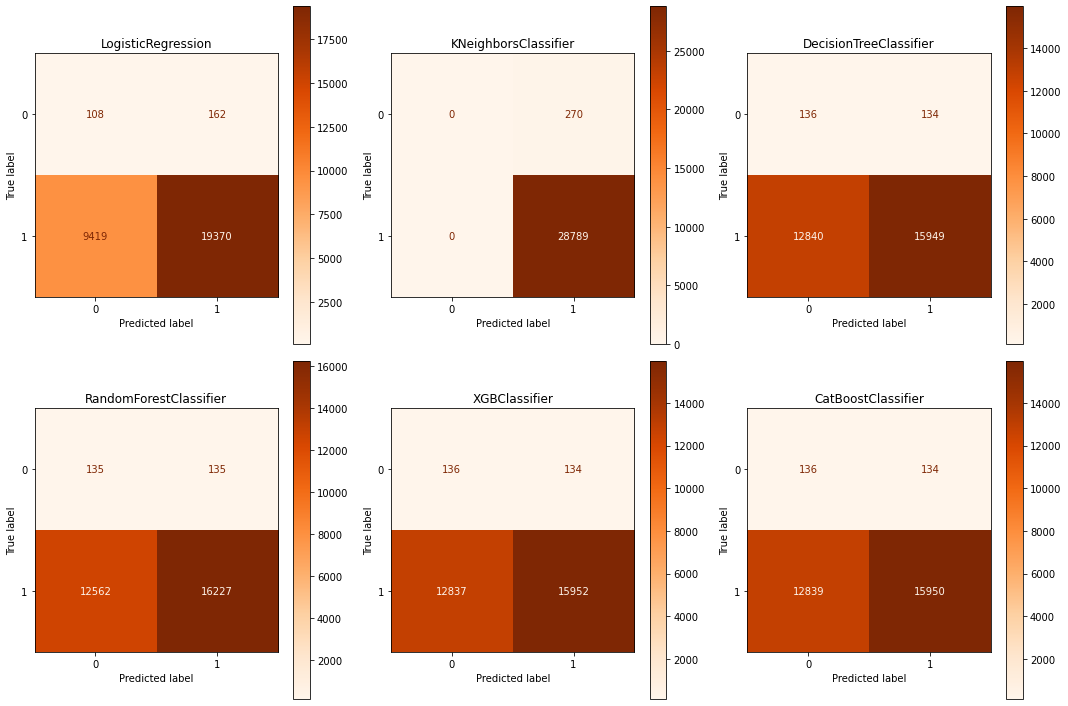

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test[selected_features], 
                          y_test, 
                          ax=ax, 
                          cmap='Oranges')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

# Performance

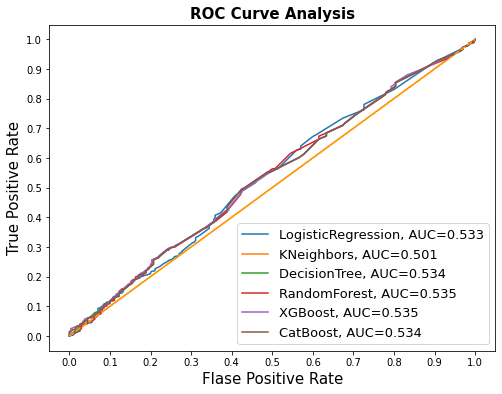

In [70]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [71]:
result_table.iloc[:,:4]

,accuracy,presicion,recall,f1_score
classifiers,,,,
LogisticRegression,0.670291,0.982597,0.670291,0.794478
KNeighbors,0.990709,0.981503,0.990709,0.986085
DecisionTree,0.553529,0.982552,0.553529,0.704452
RandomForest,0.563061,0.982633,0.563061,0.712303
XGBoost,0.553632,0.982553,0.553632,0.704538
CatBoost,0.553563,0.982552,0.553563,0.704481


# Segmentation

Create customer segmentation using RFM analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

* RECENCY (R): Days since last purchase
* FREQUENCY (F): Total number of purchases
* MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

### Recency

In [72]:
r_cust = customers[['customer_unique_id','customer_id']].merge(orders2[['customer_id','order_purchase_timestamp']], on='customer_id')
r_cust['order_purchase_timestamp'] = pd.to_datetime(r_cust['order_purchase_timestamp'])

In [73]:
r_cust['date'] = pd.DatetimeIndex(r_cust['order_purchase_timestamp']).date
r_cust

,customer_unique_id,customer_id,order_purchase_timestamp,date
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,2017-05-16
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:48:24,2018-01-12
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-19 16:07:45,2018-05-19
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 16:06:38,2018-03-13
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 09:51:30,2018-07-29
...,...,...,...,...
98202,1a29b476fee25c95fbafc67c5ac95cf8,17ddf5dd5d51696bb3d7c6291687be6f,2018-04-07 15:48:17,2018-04-07
98203,d52a67c98be1cf6a5c84435bd38d095d,e7b71a9017aa05c9a7fd292d714858e8,2018-04-04 08:20:22,2018-04-04
98204,e9f50caf99f032f0bf3c55141f019d99,5e28dfe12db7fb50a4b2f691faecea5e,2018-04-08 20:11:50,2018-04-08
98205,73c2643a0a458b49f58cea58833b192e,56b18e2166679b8a959d72dd06da27f9,2017-11-03 21:08:33,2017-11-03


In [74]:
#group by customers and check last date of purchase
recency_df = r_cust.groupby(by='customer_unique_id', as_index=False)['date'].max()
recency_df.columns = ['customer_unique_id','last_purchase_date']
recency_df

,customer_unique_id,last_purchase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08
94986,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10
94987,ffff371b4d645b6ecea244b27531430a,2017-02-07
94988,ffff5962728ec6157033ef9805bacc48,2018-05-02


In [75]:
r_cust.date.max()

datetime.date(2018, 9, 3)

In [76]:
import datetime as dt

now = dt.date(2018,9,3)
print(now)

2018-09-03


In [77]:
#calculate recency
recency_df['recency'] = recency_df['last_purchase_date'].apply(lambda x: (now - x).days)

#drop last_purchase_date
recency_df.drop('last_purchase_date',axis=1,inplace=True)

In [78]:
recency_df

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,452
94986,fffea47cd6d3cc0a88bd621562a9d061,267
94987,ffff371b4d645b6ecea244b27531430a,573
94988,ffff5962728ec6157033ef9805bacc48,124


### Frequency

In [79]:
# drop duplicates
f_cust = r_cust.copy()
f_cust.drop_duplicates(subset=['customer_unique_id', 'customer_id'], keep="first", inplace=True)

# calculate frequency of purchases
frequency_df = f_cust.groupby(by=['customer_unique_id'], as_index=False)['customer_id'].count()
frequency_df.columns = ['customer_unique_id','frequency']
frequency_df

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,1
94986,fffea47cd6d3cc0a88bd621562a9d061,1
94987,ffff371b4d645b6ecea244b27531430a,1
94988,ffff5962728ec6157033ef9805bacc48,1


### Monetary

In [80]:
m_cust = orders2[['customer_id','order_id']].merge(payments[['order_id','payment_value']], on='order_id')
m_cust = m_cust.merge(r_cust, on='customer_id')

monetary_df = m_cust.groupby(by='customer_unique_id',as_index=False)[['payment_value']].sum()
monetary_df.columns = ['customer_unique_id','monetary']
monetary_df

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
94984,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
94985,fffea47cd6d3cc0a88bd621562a9d061,84.58
94986,ffff371b4d645b6ecea244b27531430a,112.46
94987,ffff5962728ec6157033ef9805bacc48,133.69


### Create RFM table

In [81]:
temp_df = recency_df.merge(frequency_df,on='customer_unique_id')
rfm_df = temp_df.merge(monetary_df,on='customer_unique_id')

# use customer_unique_id as index
rfm_df.set_index('customer_unique_id',inplace=True)

rfm_df

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,267,1,84.58
ffff371b4d645b6ecea244b27531430a,573,1,112.46


### Customer segments with RFM Model

In [82]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary
0.25,119.0,1.0,63.10
0.50,224.0,1.0,107.90
0.75,352.0,1.0,182.94


In [83]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [84]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary'].apply(FMScore, args=('monetary',quantiles,))

In [85]:
rfm_segmentation.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1
0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4


In [86]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4,214


* Best Recency score = 4: most recently purchase 
* Best Frequency score = 4: most quantity purchase 
* Best Monetary score = 4: spent the most

In [87]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore'] == '444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile'] == 4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile'] == 4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore'] == '244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore'] == '144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore'] == '111']))

Best Customers:  535
Loyal Customers:  2888
Big Spenders:  23747
Almost Lost:  433
Lost Customers:  348
Lost Cheap Customers:  6069
